# Проект: Сборный проект №2

Стартап, который продаёт продукты питания. Нужно разобраться, как ведут себя пользователи нашего мобильного приложения. 


**Цель исследования:**
1. Изучить воронку продаж.
2. Узнать, как пользователи доходят до покупки. Сколько пользователей доходит до покупки, а сколько — «застревает» на предыдущих шагах? На каких именно?
3. Исследовать результаты A/A/B-эксперимента. Дизайнеры захотели поменять шрифты во всём приложении, а менеджеры испугались, что пользователям будет непривычно. Договорились принять решение по результатам A/A/B-теста. Пользователей разбили на 3 группы: 2 контрольные со старыми шрифтами и одну экспериментальную — с новыми. Выяснить, какой шрифт лучше.

**Ход исследования:**
Данные я получу из файла `logs_exp.csv`. О качестве данных ничего не известно. Поэтому перед тем, как приступать к целям исследования, потребуется обзор данных.

Я проверю данные и их типы на ошибки/неточности и оценю их влияние на исследование. Затем, на этапе предобработки, я поищу возможность исправить все ошибки данных, которые не приведут к искажению конечного результата. Далее создам необходимые столбцы и приступлю к проведению анализа.

Таким образом, мое исследование пройдет в 5 этапов:
- Обзор данных
- Предобработка данных
- Изучение и проверка данных
- Изучение воронки событий
- Изучение результатов эксперимента

##  Обзор данных

In [1]:
# Импортируем библиотеки
import pandas as pd
import numpy as np
from datetime import datetime, timedelta
from matplotlib import pyplot as plt
import scipy.stats as stats
import math as mth

In [2]:
data = pd.read_csv('logs_exp.csv', sep='\t')

In [3]:
data.info()
data.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 244126 entries, 0 to 244125
Data columns (total 4 columns):
 #   Column          Non-Null Count   Dtype 
---  ------          --------------   ----- 
 0   EventName       244126 non-null  object
 1   DeviceIDHash    244126 non-null  int64 
 2   EventTimestamp  244126 non-null  int64 
 3   ExpId           244126 non-null  int64 
dtypes: int64(3), object(1)
memory usage: 7.5+ MB


,EventName,DeviceIDHash,EventTimestamp,ExpId
0,MainScreenAppear,4575588528974610257,1564029816,246
1,MainScreenAppear,7416695313311560658,1564053102,246
2,PaymentScreenSuccessful,3518123091307005509,1564054127,248
3,CartScreenAppear,3518123091307005509,1564054127,248
4,PaymentScreenSuccessful,6217807653094995999,1564055322,248


**При первом взгляде на данные можно сказать, что:**

- нет пропущенных значений в датасете
- название столбцов в датасете необходимо привести к нижнему змеиному регистру
- столбец EventTimestamp в датасете необходимо заменить тип на datetime для дальнейшей работы со временем.

##  Предобработка данных

**1. Замените названия столбцов на удобные для вас**

In [4]:
data.columns=['event', 'user_id', 'timestamp', 'group']
data.head()

,event,user_id,timestamp,group
0,MainScreenAppear,4575588528974610257,1564029816,246
1,MainScreenAppear,7416695313311560658,1564053102,246
2,PaymentScreenSuccessful,3518123091307005509,1564054127,248
3,CartScreenAppear,3518123091307005509,1564054127,248
4,PaymentScreenSuccessful,6217807653094995999,1564055322,248


**2. Проверьте пропуски и типы данных. Откорректируйте, если нужно. Добавьте столбец даты и времени, а также отдельный столбец дат**

Пропуски проверены в предыдущем этапе - они отсутствуют

In [5]:
data['timestamp'] = pd.to_datetime(data['timestamp'], unit='s')
data['date'] = data['timestamp'].dt.date
data['date'] = data['date'].astype('datetime64')
data.info()
data

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 244126 entries, 0 to 244125
Data columns (total 5 columns):
 #   Column     Non-Null Count   Dtype         
---  ------     --------------   -----         
 0   event      244126 non-null  object        
 1   user_id    244126 non-null  int64         
 2   timestamp  244126 non-null  datetime64[ns]
 3   group      244126 non-null  int64         
 4   date       244126 non-null  datetime64[ns]
dtypes: datetime64[ns](2), int64(2), object(1)
memory usage: 9.3+ MB


,event,user_id,timestamp,group,date
0,MainScreenAppear,4575588528974610257,2019-07-25 04:43:36,246,2019-07-25
1,MainScreenAppear,7416695313311560658,2019-07-25 11:11:42,246,2019-07-25
2,PaymentScreenSuccessful,3518123091307005509,2019-07-25 11:28:47,248,2019-07-25
3,CartScreenAppear,3518123091307005509,2019-07-25 11:28:47,248,2019-07-25
4,PaymentScreenSuccessful,6217807653094995999,2019-07-25 11:48:42,248,2019-07-25
...,...,...,...,...,...
244121,MainScreenAppear,4599628364049201812,2019-08-07 21:12:25,247,2019-08-07
244122,MainScreenAppear,5849806612437486590,2019-08-07 21:13:59,246,2019-08-07
244123,MainScreenAppear,5746969938801999050,2019-08-07 21:14:43,246,2019-08-07
244124,MainScreenAppear,5746969938801999050,2019-08-07 21:14:58,246,2019-08-07


Значения в столбце group исправим: 246 и 247 — контрольные группы иправим на A1 и A2, а 248 — экспериментальная на B.

In [6]:
def func_group(ab_test):
    if ab_test == 246:
        return 'A1'
    elif ab_test == 247:
        return 'A2'
    elif ab_test == 248:
        return 'B'
    else:
        return 'noname_group'

data['group'] = data['group'].apply(func_group)
data.head()

,event,user_id,timestamp,group,date
0,MainScreenAppear,4575588528974610257,2019-07-25 04:43:36,A1,2019-07-25
1,MainScreenAppear,7416695313311560658,2019-07-25 11:11:42,A1,2019-07-25
2,PaymentScreenSuccessful,3518123091307005509,2019-07-25 11:28:47,B,2019-07-25
3,CartScreenAppear,3518123091307005509,2019-07-25 11:28:47,B,2019-07-25
4,PaymentScreenSuccessful,6217807653094995999,2019-07-25 11:48:42,B,2019-07-25


In [7]:
data['group'].value_counts()

B     85747
A1    80304
A2    78075
Name: group, dtype: int64

noname_group в группах для тестов отсутствуют

**3. Проверим дубликаты**

In [8]:
data.duplicated().sum()

413

Полные дубликаты, предполагаю, что есть задвоение, т.к. невозможно совершать одно и то же дествие несколько раз в одно и то же время. Поэтому удаляем дубликаты

In [9]:
data = data.drop_duplicates().reset_index()
print(data.duplicated().sum())
data

0


,index,event,user_id,timestamp,group,date
0,0,MainScreenAppear,4575588528974610257,2019-07-25 04:43:36,A1,2019-07-25
1,1,MainScreenAppear,7416695313311560658,2019-07-25 11:11:42,A1,2019-07-25
2,2,PaymentScreenSuccessful,3518123091307005509,2019-07-25 11:28:47,B,2019-07-25
3,3,CartScreenAppear,3518123091307005509,2019-07-25 11:28:47,B,2019-07-25
4,4,PaymentScreenSuccessful,6217807653094995999,2019-07-25 11:48:42,B,2019-07-25
...,...,...,...,...,...,...
243708,244121,MainScreenAppear,4599628364049201812,2019-08-07 21:12:25,A2,2019-08-07
243709,244122,MainScreenAppear,5849806612437486590,2019-08-07 21:13:59,A1,2019-08-07
243710,244123,MainScreenAppear,5746969938801999050,2019-08-07 21:14:43,A1,2019-08-07
243711,244124,MainScreenAppear,5746969938801999050,2019-08-07 21:14:58,A1,2019-08-07


Дубликаты отсутствуют. Проверим, есть ли в таблице пользователи, оказавшиеся одновременно в нескольких группах

In [10]:
double_id = data.groupby('user_id', as_index=False).agg({'group': 'nunique'})
double_id.columns=['user_id', 'group_cnt']
double_id = double_id.query('group_cnt > 1')
print(double_id)


Empty DataFrame
Columns: [user_id, group_cnt]
Index: []


Такие пользователи отсутствуют. Таблица готова к анализу.

**В результате предобработки данных сделано:**

- названия столбцов преведены к нижнему змеиному регистру
- изменили тип столбца с датой и временем, добавлен столбец с датой
- изменены типы данных со временем
- для А/А/В тестирования заменены значения в столбце group
- удалено 413 дубликатов
- проверено, что каждый пользователь присутствует только в одной из групп

## Изучение и проверка данных

**1. Сколько всего событий в логе?**

In [11]:
event_cnt = data['event'].count()
print(event_cnt)
data['event'].unique()

243713


array(['MainScreenAppear', 'PaymentScreenSuccessful', 'CartScreenAppear',
       'OffersScreenAppear', 'Tutorial'], dtype=object)

Всего событий в логе - 243713. Уникальных - 5 шт.

**2. Сколько всего пользователей в логе?**

In [12]:
user_cnt = data['user_id'].nunique()
print(user_cnt)

7551


Всего пользователей в логе - 7551

**3. Сколько в среднем событий приходится на пользователя?**

In [13]:

print("Среднее количество событий на пользователя:", (event_cnt / user_cnt))

Среднее количество событий на пользователя: 32.27559263673685


In [14]:
event_user = data.groupby('user_id')['event'].count()
event_user.describe()

count    7551.000000
mean       32.275593
std        65.154219
min         1.000000
25%         9.000000
50%        20.000000
75%        37.000000
max      2307.000000
Name: event, dtype: float64

Если посмотреть в целом на данные, то видно выбросы, которые достигаю максимального значения - 2307, также видно, что стандартное отклонение высокое и медиана отличается от среднего, поэтому стоит равняться на медиану - 20.

**4. Данными за какой период вы располагаете? Найдите максимальную и минимальную дату. Постройте гистограмму по дате и времени. Можно ли быть уверенным, что у вас одинаково полные данные за весь период? Технически в логи новых дней по некоторым пользователям могут «доезжать» события из прошлого — это может «перекашивать данные». Определите, с какого момента данные полные и отбросьте более старые. Данными за какой период времени вы располагаете на самом деле?**

In [15]:
print(f"Минимальная дата: {data['timestamp'].min()}")
print(f"Максимальная дата: {data['timestamp'].max()}")
print(f"Стартовы размер периода данных : {data['timestamp'].max() - data['timestamp'].min()}")

Минимальная дата: 2019-07-25 04:43:36
Максимальная дата: 2019-08-07 21:15:17
Стартовы размер периода данных : 13 days 16:31:41


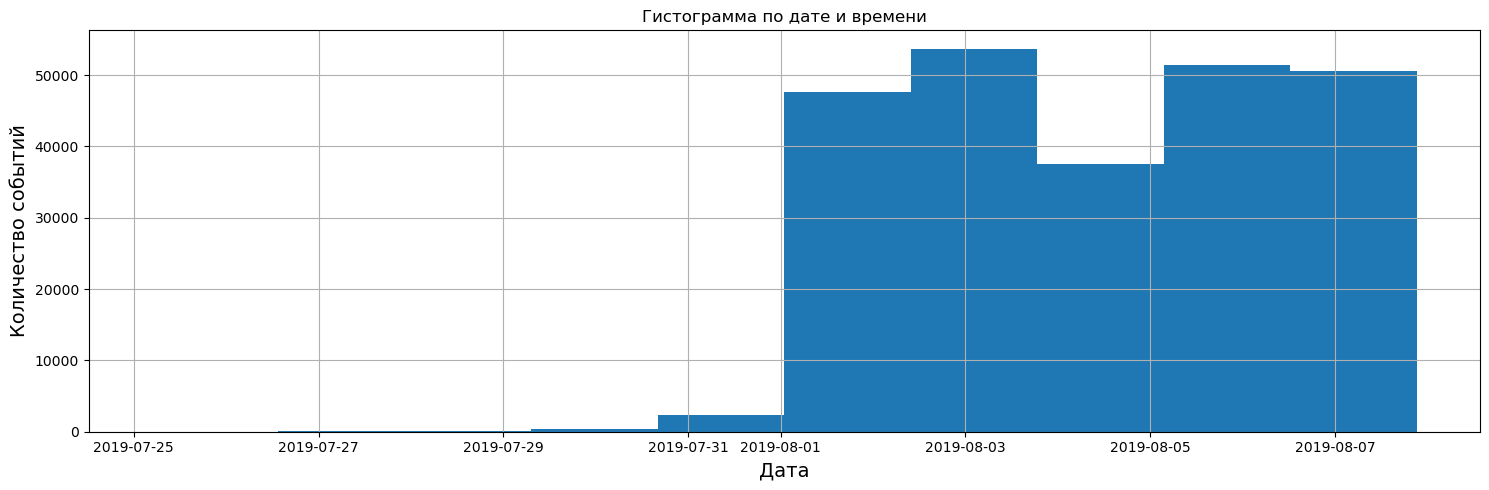

In [16]:
plt.figure(figsize=(15,5))
plt.grid()
plt.title('Гистограмма по дате и времени')
plt.hist(data['timestamp']) 
# добавляем подписи к осям и заголовок диаграммы
plt.xlabel('Дата', fontsize=14)
plt.ylabel('Количество событий', fontsize=14)


# оптимизируем поля и расположение объектов
plt.tight_layout()

plt.show()

Фактически мы располагаем полными дынными с 1 августа 2019. Данные в последней недели июля содержат очень мало событий. 

Поэтому отбросим данные, которые были совершены до 1 августа.

In [17]:
data = data.loc[data['date'] > '2019-07-31'].reset_index(drop=True)
data.sort_values(by='date')

,index,event,user_id,timestamp,group,date
0,2828,Tutorial,3737462046622621720,2019-08-01 00:07:28,A1,2019-08-01
24103,26973,CartScreenAppear,4933689529142781210,2019-08-01 15:42:14,A1,2019-08-01
24102,26972,MainScreenAppear,5375697691143223385,2019-08-01 15:42:13,A2,2019-08-01
24101,26971,MainScreenAppear,5122452238037348165,2019-08-01 15:42:12,B,2019-08-01
24100,26970,MainScreenAppear,370831337408248129,2019-08-01 15:42:10,A2,2019-08-01
...,...,...,...,...,...,...
220148,223350,MainScreenAppear,1599641448679221409,2019-08-07 10:13:46,A2,2019-08-07
220147,223349,MainScreenAppear,6713384618608633696,2019-08-07 10:13:44,A2,2019-08-07
220146,223348,MainScreenAppear,3063248032210795834,2019-08-07 10:13:41,A2,2019-08-07
220174,223376,MainScreenAppear,6953415790057009349,2019-08-07 10:14:36,B,2019-08-07


В итоге располагаем данными за период с 1 августа по 7 августа 2019 года

**Много ли событий и пользователей вы потеряли, отбросив старые данные?**

In [18]:
new_users = data['user_id'].nunique()
new_events = data['event'].count()
print(f'Стало меньше пользователей на {user_cnt-new_users}')
print(f'% потери пользователей = {round((user_cnt-new_users)/user_cnt*100, 2)}%')
print(f'Стало меньше событий на {event_cnt-new_events}')
print(f'% потери событий = {round((event_cnt-new_events)/event_cnt*100, 2)}%')

Стало меньше пользователей на 17
% потери пользователей = 0.23%
Стало меньше событий на 2826
% потери событий = 1.16%


Если смотреть на процент потери пользователей и событий, то в обоих случаях он не превышает 1,5%, что вполне допустимо

**Проверьте, что у вас есть пользователи из всех трёх экспериментальных групп.**

In [19]:
data.groupby('group')['user_id'].nunique()

group
A1    2484
A2    2513
B     2537
Name: user_id, dtype: int64

В каждой группе примерно одинаковое количество пользователей - около 2500 шт.

**ВЫВОД:**
- Всего событий в логе - 243713. Уникальных - 5 шт.
- Всего пользователей в логе - 7551
- Медианное количество событий на пользователя 20 шт.
- Фактически мы располагаем полными дынными с 1 августа 2019 по 7 августа 2019. Данные в последней недели июля содержат очень мало событий.
- В каждой группе примерно одинаковое количество пользователей - около 2500 шт.

## Изучение и проверка данных

**Посмотрите, какие события есть в логах, как часто они встречаются. Отсортируйте события по частоте.**

In [20]:
data['event'].value_counts()

MainScreenAppear           117328
OffersScreenAppear          46333
CartScreenAppear            42303
PaymentScreenSuccessful     33918
Tutorial                     1005
Name: event, dtype: int64

- Подавляющее польшинство событий - Появление Главного экрана, что не удивительно - все пользователи сначала попадают на первый экран
- Похожее количество событий у Появление Экрана Предложений, Появление Экрана Корзины и Экран Платеж Совершен. 
- Страницу Руководство - посещают меньше всего. События здесь незначительны.

**Посчитайте, сколько пользователей совершали каждое из этих событий. Отсортируйте события по числу пользователей. Посчитайте долю пользователей, которые хоть раз совершали событие.**

In [21]:
events_users = data.groupby('event').agg({'event':'count', 'user_id':'nunique'}).sort_values(by='user_id', ascending=False)
events_users.columns = ['cnt_events', 'users']
events_users['users_per_event'] = (events_users['users'] / new_users * 100).round(2) # доля хотя бы раз совершивших событие
events_users.reset_index()

,event,cnt_events,users,users_per_event
0,MainScreenAppear,117328,7419,98.47
1,OffersScreenAppear,46333,4593,60.96
2,CartScreenAppear,42303,3734,49.56
3,PaymentScreenSuccessful,33918,3539,46.97
4,Tutorial,1005,840,11.15


Доля и число пользователей коррилируется с предыдущим выводом

**Предположите, в каком порядке происходят события. Все ли они выстраиваются в последовательную цепочку? Их не нужно учитывать при расчёте воронки.**

Предполагаю, что события выстраиваются в последовательную цепочку согласно убыванию количества пользователей. Это логично. Сначала идет главный экран - даоее пользователи видят предложение, добавляют в корзину и оплачивают покупку.

Событие Руководство в цепочку не входит, т.к. оно, логично предположить, является вспомогательным ресурсом для пользователей.

**По воронке событий посчитайте, какая доля пользователей проходит на следующий шаг воронки (от числа пользователей на предыдущем). То есть для последовательности событий A → B → C посчитайте отношение числа пользователей с событием B к количеству пользователей с событием A, а также отношение числа пользователей с событием C к количеству пользователей с событием B.**

In [22]:
events_users['conversion'] = round(events_users['users'] / events_users['users'].shift(1), 2)
events_users

,cnt_events,users,users_per_event,conversion
event,,,,
MainScreenAppear,117328,7419,98.47,NaN
OffersScreenAppear,46333,4593,60.96,0.62
CartScreenAppear,42303,3734,49.56,0.81
PaymentScreenSuccessful,33918,3539,46.97,0.95
Tutorial,1005,840,11.15,0.24


**На каком шаге теряете больше всего пользователей?**

Максимальное количество пользователей (38%) теряем на моменте перехода с главного этапа на второй этап (OffersScreenAppear) с выбором товара. Возможно есть какая-то проблема на первом экране (MainScreenAppear), либо не расскрыто предложение с маркетинговой точки зрения. Однако, необходимо уточнить текущую конверсию сайта у маркетологов, возможно 62% это хороший результат.

**Какая доля пользователей доходит от первого события до оплаты?**

Из таблицы видно, что 46,97% пользователей доходит до страницы "PaymentScreenSuccessful" с успешной оплатой. Хороший результат

**ВЫВОД:**
- Подавляющее польшинство событий - Появление Главного экрана,  далее с Похожим количеством событий идут Появление Экрана Предложений, Появление Экрана Корзины и Экран Платеж Совершен. Страницу Руководство - посещают меньше всего. События здесь незначительны. 
- Сккорее всего события выстраиваются в последовательную цепочку согласно убыванию количества пользователей. Сначала идет главный экран - даоее пользователи видят предложение, добавляют в корзину и оплачивают покупку. Событие Руководство в цепочку не входит, т.к. оно, логично предположить, является вспомогательным ресурсом для пользователей.
- Максимальное количество пользователей (38%) теряем на моменте перехода с главного этапа на второй этап (OffersScreenAppear) с выбором товара. Возможно есть какая-то проблема на первом экране (MainScreenAppear), либо не расскрыто предложение с маркетинговой точки зрения. Однако, необходимо уточнить текущую конверсию сайта у маркетологов, возможно 62% это хороший результат.
- 46,97% пользователей доходит до страницы "PaymentScreenSuccessful" с успешной оплатой. Хороший результат

##  Изучение и проверка данных

**Сколько пользователей в каждой экспериментальной группе?**

In [23]:
data.groupby('group')['user_id'].nunique()

group
A1    2484
A2    2513
B     2537
Name: user_id, dtype: int64

В группах примерно сопоставимое распределение количества пользователей

**Есть 2 контрольные группы для А/А-эксперимента, чтобы проверить корректность всех механизмов и расчётов. Проверьте, находят ли статистические критерии разницу между выборками 246 и 247.**

In [24]:
users_bygroup = data.groupby('group')['user_id'].nunique()
users_bygroup['A1+A2'] = users_bygroup['A1'] + users_bygroup['A2']
users_bygroup

group
A1       2484
A2       2513
B        2537
A1+A2    4997
Name: user_id, dtype: int64

In [25]:
event_group_test = data[data['event']!='Tutorial'].pivot_table(
    index='event', 
    columns='group', 
    values='user_id',
    aggfunc='nunique').sort_values(by='A1', ascending=False)

event_group_test = event_group_test.reset_index()
event_group_test['A1+A2'] = event_group_test['A1'] + event_group_test['A2']
event_group_test['all'] = event_group_test['A1+A2'] + event_group_test['B']

event_group_test['part_A1'] = (event_group_test['A1'] / users_bygroup['A1'] * 100).round(1)
event_group_test['part_A2'] = (event_group_test['A2'] / users_bygroup['A2'] * 100).round(1)
event_group_test['part_B'] = (event_group_test['B'] / users_bygroup['B'] * 100).round(1)
event_group_test['part_A1+A2'] = ((event_group_test['A1'] + event_group_test['A2']) / \
                                  (users_bygroup['A1'] + users_bygroup['A2']) * 100).round(1)
# event_group_test['part_all'] = (event_group_test['all'] / users_bygroup.sum() * 100).round(1)
event_group_test

group,event,A1,A2,B,A1+A2,all,part_A1,part_A2,part_B,part_A1+A2
0,MainScreenAppear,2450,2476,2493,4926,7419,98.6,98.5,98.3,98.6
1,OffersScreenAppear,1542,1520,1531,3062,4593,62.1,60.5,60.3,61.3
2,CartScreenAppear,1266,1238,1230,2504,3734,51.0,49.3,48.5,50.1
3,PaymentScreenSuccessful,1200,1158,1181,2358,3539,48.3,46.1,46.6,47.2


Критерии успешного A/A-теста:

- Количество пользователей в различных группах различается не более, чем на 1%;
- Для всех групп фиксируют и отправляют в системы аналитики данные об одном и том же;
- Различие ключевых метрик по группам не превышает 1% и не имеет статистической значимости;
- Попавший в одну из групп посетитель остаётся в этой группе до конца теста. Если пользователь видит разные версии исследуемой страницы в ходе одного исследования, неизвестно, какая именно повлияла на его решения. Значит, и результаты такого теста нельзя интерпретировать однозначно.

Степень различия ключевых метрик по группам зависит от необходимой чувствительности эксперимента. Скажем, если вы хотите определить результаты теста, в котором ожидаете не менее 30% прироста, то 10% погрешности измерений вас устроят. Однако такое бывает редко: изменение показателей на 30% обычно заметно и без A/B-теста. Его применяют там, где степень различия между группами не больше 10%, или же подвержены колебаниям. В таких случаях точность A/A-теста в 1% — распространённый критерий.

**Есть 2 контрольные группы для А/А-эксперимента, чтобы проверить корректность всех механизмов и расчётов. Проверьте, находят ли статистические критерии разницу между выборками 246 и 247.**

In [26]:
def z_test(group1, group2, alpha):
    for i in event_group_test.index:
        p1 = event_group_test[group1][i] / users_bygroup[group1]
        # пропорция успехов во второй группе:
        p2 = event_group_test[group2][i] / users_bygroup[group2]
        # пропорция успехов в комбинированном датасете:
        p_combined = ((event_group_test[group1][i] + event_group_test[group2][i]) / 
                      (users_bygroup[group1] + users_bygroup[group2]))
        # разница пропорций в датасетах
        difference = p1 - p2
        # считаем статистику в ст.отклонениях стандартного нормального распределения
        z_value = difference / mth.sqrt(p_combined * (1 - p_combined) * 
                                        (1/users_bygroup[group1] + 1/users_bygroup[group2]))
        # задаем стандартное нормальное распределение (среднее 0, ст.отклонение 1)
        distr = stats.norm(0, 1) 
        p_value = (1 - distr.cdf(abs(z_value))) * 2
        print('{} p-значение: {}'.format(event_group_test['event'][i], p_value))
        if (p_value < alpha):
            print("Отвергаем нулевую гипотезу: между долями есть значимая разница")
        else:
            print("Не получилось отвергнуть нулевую гипотезу, нет оснований считать доли разными")
        print('')
        
z_test("A1", "A2", 0.01)

MainScreenAppear p-значение: 0.7570597232046099
Не получилось отвергнуть нулевую гипотезу, нет оснований считать доли разными

OffersScreenAppear p-значение: 0.2480954578522181
Не получилось отвергнуть нулевую гипотезу, нет оснований считать доли разными

CartScreenAppear p-значение: 0.22883372237997213
Не получилось отвергнуть нулевую гипотезу, нет оснований считать доли разными

PaymentScreenSuccessful p-значение: 0.11456679313141849
Не получилось отвергнуть нулевую гипотезу, нет оснований считать доли разными




Для проведения A/A тестирования был взят уровень статистической значимости равный 1%. Различий между выборками А/А-теста не выявлено, поэтому эти группы считаем контрольными.

**Выберите самое популярное событие. Посчитайте число пользователей, совершивших это событие в каждой из контрольных групп. Посчитайте долю пользователей, совершивших это событие. Проверьте, будет ли отличие между группами статистически достоверным. Проделайте то же самое для всех других событий (удобно обернуть проверку в отдельную функцию). Можно ли сказать, что разбиение на группы работает корректно?**

Ответы беру из таблицы выше.
- Самое популярное событие - это "MainScreenAppear"

- Число пользователей совершивших самое популярное событие "MainScreenAppear" - 7423, в разрезе групп:

A1 - 2450
A2 - 2476
B - 2493
- Доли пользователей совершивших самое популярное событие "MainScreenAppear" - 98% по всем группам.

A1 - 98,6%
A2 - 98,5%
B - 98,3%

Отличия незначительны. разбивка на группы работает корректно.

**Аналогично поступите с группой с изменённым шрифтом. Сравните результаты с каждой из контрольных групп в отдельности по каждому событию. Сравните результаты с объединённой контрольной группой. Какие выводы из эксперимента можно сделать?**

Для дальнейших экспериментов выберем самый стандартный уровень значимости равный 5%. 

In [27]:
z_test("A1", "B", 0.05)

MainScreenAppear p-значение: 0.2949721933554552
Не получилось отвергнуть нулевую гипотезу, нет оснований считать доли разными

OffersScreenAppear p-значение: 0.20836205402738917
Не получилось отвергнуть нулевую гипотезу, нет оснований считать доли разными

CartScreenAppear p-значение: 0.07842923237520116
Не получилось отвергнуть нулевую гипотезу, нет оснований считать доли разными

PaymentScreenSuccessful p-значение: 0.2122553275697796
Не получилось отвергнуть нулевую гипотезу, нет оснований считать доли разными



In [28]:
z_test("A2", "B", 0.05)

MainScreenAppear p-значение: 0.4587053616621515
Не получилось отвергнуть нулевую гипотезу, нет оснований считать доли разными

OffersScreenAppear p-значение: 0.9197817830592261
Не получилось отвергнуть нулевую гипотезу, нет оснований считать доли разными

CartScreenAppear p-значение: 0.5786197879539783
Не получилось отвергнуть нулевую гипотезу, нет оснований считать доли разными

PaymentScreenSuccessful p-значение: 0.7373415053803964
Не получилось отвергнуть нулевую гипотезу, нет оснований считать доли разными



In [29]:
z_test("A1+A2", "B", 0.05)

MainScreenAppear p-значение: 0.29424526837179577
Не получилось отвергнуть нулевую гипотезу, нет оснований считать доли разными

OffersScreenAppear p-значение: 0.43425549655188256
Не получилось отвергнуть нулевую гипотезу, нет оснований считать доли разными

CartScreenAppear p-значение: 0.18175875284404386
Не получилось отвергнуть нулевую гипотезу, нет оснований считать доли разными

PaymentScreenSuccessful p-значение: 0.6004294282308704
Не получилось отвергнуть нулевую гипотезу, нет оснований считать доли разными



**Значимой разницы между группами во всех тестах не выявлено**

**Какой уровень значимости вы выбрали при проверке статистических гипотез выше? Посчитайте, сколько проверок статистических гипотез вы сделали. При уровне значимости 0.1 каждый десятый раз можно получать ложный результат. Какой уровень значимости стоит применить? Если вы хотите изменить его, проделайте предыдущие пункты и проверьте свои выводы.**

- В ходе проверки гипотез был выбран уровень значимости для A/А теста - 1%, для остальных - 5%.
- Всего в ходе тестирования были проведены 16 проверок гипотез по 4 для каждой группы
- При уровне значимости 0.1 только одна из 12 проверок покажет значимую разницу, между контрольной группой A1 и экспериментальной. что будет плохо для эксперимента, поэтому оставим изначально выбранный нами уровень значимости 0.05.

При сравнении двух групп вероятность ошибочно отвергнуть нулевую гипотезу 0.05, все здесь окей. Однако, при добавлении еще одной группы из той же совокупности -  точно такая же ошибка возможна в случае сравнения новой группы с двумя другими. Следовательно, вероятность ошибиться для трех групп уже не 0.05, а больше.

## Вывод

**1. В результате предобработки данных сделано:**

- названия столбцов преведены к нижнему змеиному регистру
- изменили тип столбца с датой и временем, добавлен столбец с датой
- изменены типы данных со временем
- для А/А/В тестирования заменены значения в столбце group
- удалено 413 дубликатов
- проверено, что каждый пользователь присутствует только в одной из групп

**2. При изучении событий было выявлено:**

- Всего событий в логе - 243713. Уникальных - 5 шт.
- Всего пользователей в логе - 7551
- Медианное количество событий на пользователя 20 шт.
- Фактически мы располагаем полными дынными с 1 августа 2019 по 7 августа 2019. Данные в последней недели июля содержат очень мало событий.
- В каждой группе примерно одинаковое количество пользователей - около 2500 шт.

**3. При изучении воронки выявили:**

- Подавляющее польшинство событий - Появление Главного экрана,  далее с Похожим количеством событий идут Появление Экрана Предложений, Появление Экрана Корзины и Экран Платеж Совершен. Страницу Руководство - посещают меньше всего. События здесь незначительны. 
- Сккорее всего события выстраиваются в последовательную цепочку согласно убыванию количества пользователей. Сначала идет главный экран - даоее пользователи видят предложение, добавляют в корзину и оплачивают покупку. Событие Руководство в цепочку не входит, т.к. оно, логично предположить, является вспомогательным ресурсом для пользователей.
- Максимальное количество пользователей (38%) теряем на моменте перехода с главного этапа на второй этап (OffersScreenAppear) с выбором товара. Возможно есть какая-то проблема на первом экране (MainScreenAppear), либо не расскрыто предложение с маркетинговой точки зрения. Однако, необходимо уточнить текущую конверсию сайта у маркетологов, возможно 62% это хороший результат.
- 46,97% пользователей доходит до страницы "PaymentScreenSuccessful" с успешной оплатой. Хороший результат

**4. Результаты эксперимента:**

- В результате всех и каждого A/A/B эксперемента значимой разницы между группами не выявлено. Поэтому можно утверждать, что на поведение пользователей изменение шрифта не оказало. Тестирование можно назвать успешным - изменение шрифта не повлияло на поведение пользователей.